## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#### Visualization Variables

In [2]:
width, height = 10, 4

## Implementation

In [3]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=4, min_samples=2, criterion='gini_index'):
        """
        Constructor that initializes the Decision Tree Object.
            Parameters:
                max_depth (int): Maximum depth for the tree to reach
                min_samples (int): Minimum number of samples on which to split a node
                criterion (str): Criterion on which to measure the impurity of a node
        """
        self.root = None
        self.max_depth = max_depth
        self.min_samples = min_samples

        criteria = {'gini_index': self.gini_index, 
                  'entropy': self.entropy}
        
        self.get_impurity = criteria.get(criterion, None)
        
        if self.get_impurity == None:
            raise Exception(("Passed criterion not recognized. "
                            f"Please choose from ({', '.join(criteria.keys())})"))
    
    def draw_tree(self, tree=None):
        """
        Draws a decision tree using maptlotlib for visualizing the tree with the nodes, their condition, 
        and its information gain.
            Parameters:
                tree (<DecisionTreeClassifier> object): tree object to draw (optional)
        """
        if not tree:
            tree = self.root
            
        rlevel = self.get_level()
        _, ax  = plt.subplots(figsize=(rlevel*4**1.3, rlevel*2**1.5))
        ax.plot([45, 50], [rlevel*7+(height/2), rlevel*7+(height/2)], linewidth=0.01)
        tree.draw(0, 100, ax, rlevel)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    class Node():
        
        colors = ['blue', 'red', 'green']
        
        def __init__(self, feature=None, value=None, left_node=None, right_node=None, gain=None, target=None, depth=0):
            """
            Constructor that initializes the Node Object.
                Parameters:
                    feature (str): feature column name in the (pandas) datafarme
                    value (float): value that sets the threshold for the condition
                    left_node (<Node> object): node object for the samples that fulfill the condition
                    right_node (<Node> object): node object for the samples that do not fulfill the condition
                    gain (float): information gain by the split of this node
                    target (str/float): the final output value, in case this is a leaf node
            """
            self.target = target
            self.depth = depth
            self.feature = feature
            self.value = value
            self.gain = gain
            self.left_node = left_node
            self.right_node = right_node
        
        def draw(self, leftx, rightx, ax=None, rlevel=None, sign=0):
            """
            Draws node with it's children nodes
                Parameters:
                    leftx (float): left x coordinate limit 
                    rightx (float): right x coordinate limit 
                    ax (<matplotlib.axes.Axes> object): axes on which the nodes are being drawn
                    rlevel (<Node> object): reversed level number that acts as a y-coordinate (tree depth - node depth)
                    sign (int): a number resembling the direction of a split (+ve means right split, -ve means left split)
            """
            # Get level but in reverse (so root is on top)
            if rlevel is None:
                rlevel = self.get_level()

            # Create figure depending on the number of levels in the tree
            if ax is None:
                _, ax  = plt.subplots(figsize=(rlevel*2, rlevel))

            # Get midpoint
            midpointx = (rightx+leftx) / 2

            
            
            if sign<0:
                ax.arrow(rightx, ((rlevel+1)*7-(height/2)), -(rightx-leftx)/2, -7+height, width = 0.05)
            elif sign>0:
                ax.arrow(leftx, ((rlevel+1)*7-(height/2)), (rightx-leftx)/2, -7+height, width = 0.05)
            
            if not self.target is None:
                # Create a Rectangle patch
                rect = patches.Rectangle((midpointx-width/2, rlevel*7-height/2), 
                                         width, height, linewidth=1, 
                                         edgecolor=self.colors[self.target], facecolor=self.colors[self.target])
                # Add the patch to the Axes
                ax.add_patch(rect)
            
                label = f"{self.target}"
                ax.annotate(label, xy=(midpointx, rlevel*7), ha='center', va='center', c='white', fontsize=12)
                return
            
            # Create a Rectangle patch
            rect = patches.Rectangle((midpointx-width/2, rlevel*7-height/2), 
                                     width, height, linewidth=1, edgecolor='black', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

            # Create Annotation
            label = f"{self.feature}\ngain: {self.gain:.2f}\n>= {self.value:.2f}"

            # Annotate on the Axes
            ax.annotate(label, xy=(midpointx, rlevel*7), ha='center', va='center', fontsize=12)

            # Draw left and right nodes
            self.left_node.draw(leftx, midpointx, ax, rlevel-1, -1)
            self.right_node.draw(midpointx, rightx, ax, rlevel-1, 1)
            
    def fit(self, df):
        """
        Fits the decision tree on the passed dataframe
            Parameters:
                df (<pandas.DataFrame> object): pandas dataframe object where columns are feature and target names, and 
                    rows are the samples. (target column should be the last)
        """
        self.root = self.build_tree(df)
        self.targets = df.iloc[-1].unique().tolist()
        
        return self
    
    def get_depth(self, tree=None):
        """
        Calculates and returns the depth of the tree
            Parameters:
                tree (<DecisionTreeClassifier> object): tree object to draw (optional)
            Returns:
                (int): depth of the tree
        """
        if not tree:
            tree = self.root
        if not tree.target is None:
            return tree.depth
        
        return max(self.get_depth(tree.left_node), self.get_depth(tree.right_node))
    
    def get_level(self, tree=None):
        """
        Calculates and returns the number of levels in the tree (depth+1)
            Parameters:
                tree (<DecisionTreeClassifier> object): tree object to draw (optional)
            Returns:
                (int): number of levels
        """
        if not tree:
            tree = self.root
        if not tree.target is None:
            return 1
        
        return 1 + max(self.get_level(tree.left_node), self.get_level(tree.right_node))
        
    def build_tree(self, df, depth=0):
        """
        Builds the tree and returns the root node. (recursive function)
            Parameters:
                df (<pandas.DataFrame> object): pandas dataframe object where columns are feature and target names, and 
                    rows are the samples. (target column should be the last)
                depth (int): current node depth (root node being of 0 depth)
            Returns:
                (<DecisionTreeClassifier.Node> object): Node object
        """
        if (depth < self.max_depth) & (df.shape[0] >= self.min_samples):
            best_split = self.get_split(df)
            
            if best_split.get('gain', 0) > 0:
                left_node  = self.build_tree(best_split['left'], depth+1)
                right_node = self.build_tree(best_split['right'] , depth+1)
                
                return self.Node(feature=best_split['feature'], 
                            value=best_split['value'], 
                            gain=best_split['gain'],
                            left_node=left_node, 
                            right_node=right_node, )
        
        return self.Node(target=df.iloc[:, -1].value_counts().idxmax(), depth=depth)

    
    def get_split(self, df):
        """
        Finds the feature and threshold with the highest information gain.
            Parameters:
                df (<pandas.DataFrame> object): pandas dataframe object where columns are feature and target names, and 
                    rows are the samples. (target column should be the last)
            Returns:
                best_split (dictionary): dictionary containing values specifying the split feature, threshold value, gain,
                    left dataframe, and right dataframe.
        """
        best_split = {}
        
        for feature in df.columns[:-1]:
#             print(feature)
            series = df.loc[:, feature]
            values = series.unique()
            values.sort()
            values = ((values[:-1] + values[1:]) / 2).copy()
            
            for value in values:
                
                cond = (series >= value)

                df1 = df[cond].copy()
                df2 = df[~cond].copy()

                gain = self.gain(df.iloc[:,-1].copy(), 
                                 df1.iloc[:,-1].copy(), 
                                 df2.iloc[:,-1].copy())
#                 print(gain)
                if gain > best_split.get("gain", -np.inf):
#                     print(f"{feature} better gain: {gain:.2f}")
                    best_split = {"feature": feature, 
                                  "value": value, 
                                  "left": df1, 
                                  "right": df2,
                                  "gain": gain}

        return best_split

    
    def entropy(self, y):
        """
        Calculates a node's samples entropy.
            Parameters:
                y (<pandas.Series> object): pandas series object containing the samples' target values
            Returns:
                (float): entropy impurity value (0 to 1)
        """
        probs = (y.value_counts() / len(y))
        return -((probs * np.log2(probs)).sum())


    def gini_index(self, y):
        """
        Calculates a node's samples gini-index.
            Parameters:
                y (<pandas.Series> object): pandas series object containing the samples' target values
            Returns:
                (float): gini-index impurity value (0 to 1)
        """
        probs = (y.value_counts() / len(y))
        return (1 - np.power(probs, 2).sum())


    def gain(self, y, y1, y2):
        """
        Calculates a node's split information gain.
            Parameters:
                y (<pandas.Series> object): parent node pandas series object containing the samples' target values
                y1 (<pandas.Series> object): child left-node pandas series object containing the samples' target values
                y2 (<pandas.Series> object): child right-node parent pandas series object containing the samples' target values
                
            Returns:
                info_gain (float): information gain value
        """
        impurity  = self.get_impurity(y)
        impurity1 = self.get_impurity(y1)
        impurity2 = self.get_impurity(y2)

        info_gain = impurity - \
            (((len(y1) / len(y)) * impurity1) + \
             ((len(y2) / len(y)) * impurity2))

        return info_gain
    
    def score(self, df):
        """
        Calculates the prediction score on the passed (pandas) dataframe.
            Parameters:
                df (<pandas.DataFrame> object): pandas dataframe object where columns are feature and target names, and 
                    rows are the samples. (target column should be the last)
            Returns:
                (<pandas.Series> object): pandas series object containing the samples' predicted values
                (float): samples mean score (0 to 1 for 0% to 100% score) 
        """
        df['predict'] = df.iloc[:,-1]
        for row_index in range(df.shape[0]):
            df.iloc[row_index, -1] = self.predict_sample(df.iloc[row_index:row_index+1, :-2].copy(), self.root)
        
        return (df.iloc[:,-1], np.mean(df.iloc[:,-2]==df.iloc[:,-1]))
    
    def predict_sample(self, sample, tree):
        """
        Calculates the prediction score on the passed (pandas) dataframe.
            Parameters:
                sample (<pandas.DataFrame> object): pandas dataframe object where columns are feature and target names, and 
                    only one row being the sample. (target column should be the last)
                tree (<DecisionTreeClassifier> object): tree object to draw (optional)
            Returns:
                (<pandas.Series> object): pandas series object containing the samples' predicted values
                (float): samples mean score (0 to 1 for 0% to 100% score) 
        """
        if not tree.target is None: return tree.target
        
        if sample[tree.feature].item() >= tree.value:
            return self.predict_sample(sample, tree.left_node)
        else:
            return self.predict_sample(sample, tree.right_node)

---

## Read Data

In [4]:
df = pd.read_csv('data/breast_cancer_data.csv')

In [5]:
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


## Split data for training and testing

In [6]:
train = df.sample(200)#['diagnosis'].value_counts()
test = df.drop(train.index)
print("train data:")
display(pd.concat([train['diagnosis'].value_counts(), train['diagnosis'].value_counts(normalize=True)], axis=1))
print("test data:")
display(pd.concat([test['diagnosis'].value_counts(), test['diagnosis'].value_counts(normalize=True)], axis=1))

train data:


,diagnosis,diagnosis
1,100,0.5
0,100,0.5


test data:


,diagnosis,diagnosis
0,99,0.5
1,99,0.5


## Instantiation a Tree Object
##### with entropy as criterion for information gain

In [7]:
dt = DecisionTreeClassifier(criterion='entropy')

## Fit and Draw Tree

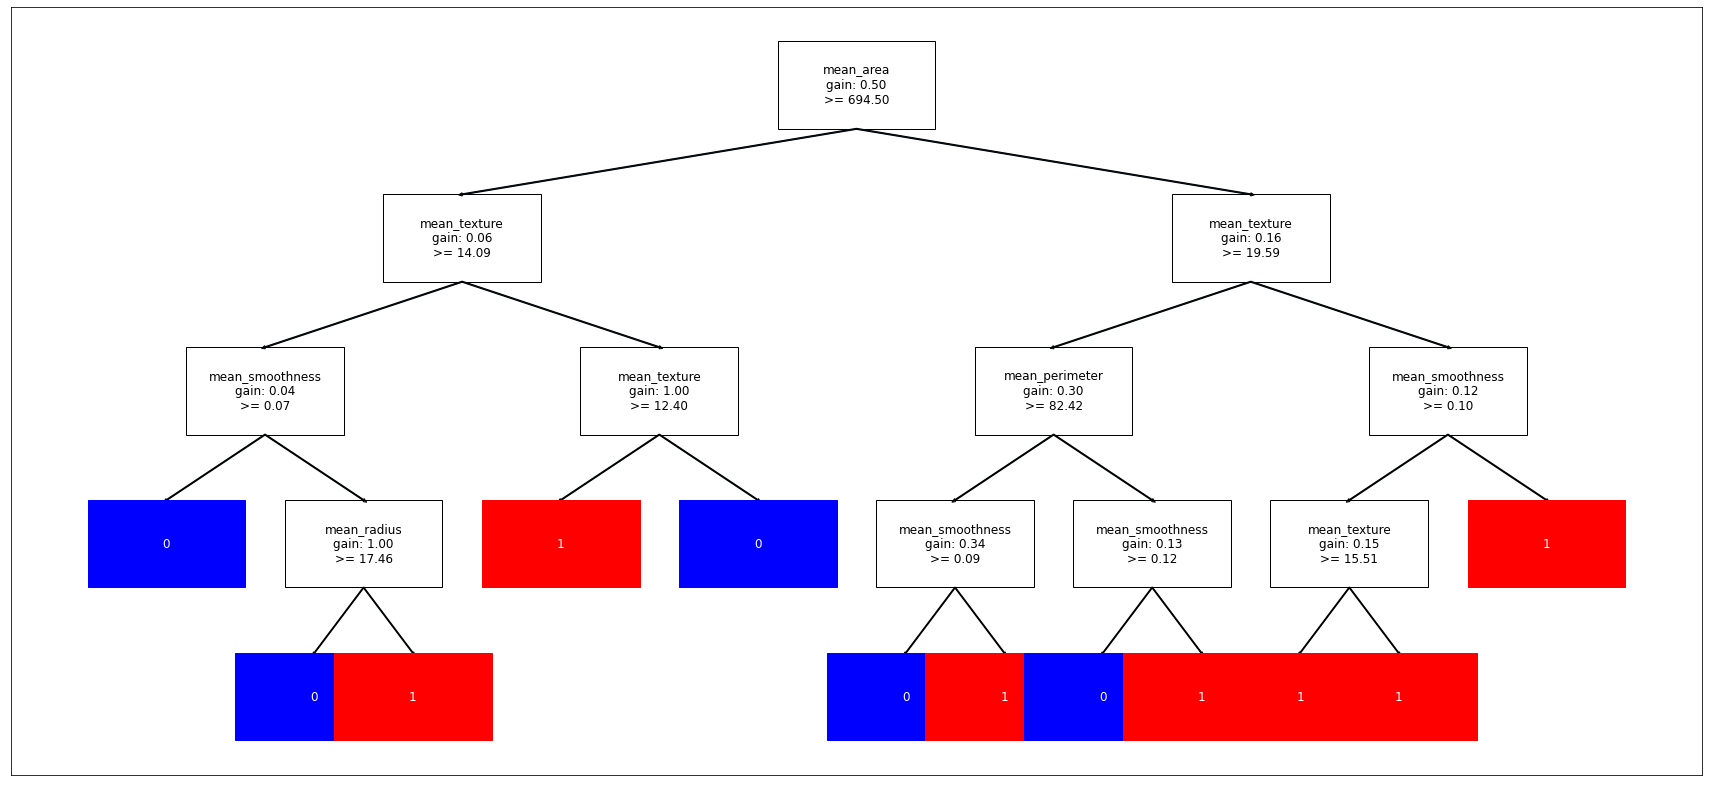

In [8]:
dt.fit(df)
dt.draw_tree()

# Get score on Testing Dataset

In [9]:
predicts, score = dt.score(test)
print(f"score: {score*100:.2f}%")

score: 93.43%


## Try with Gini Index

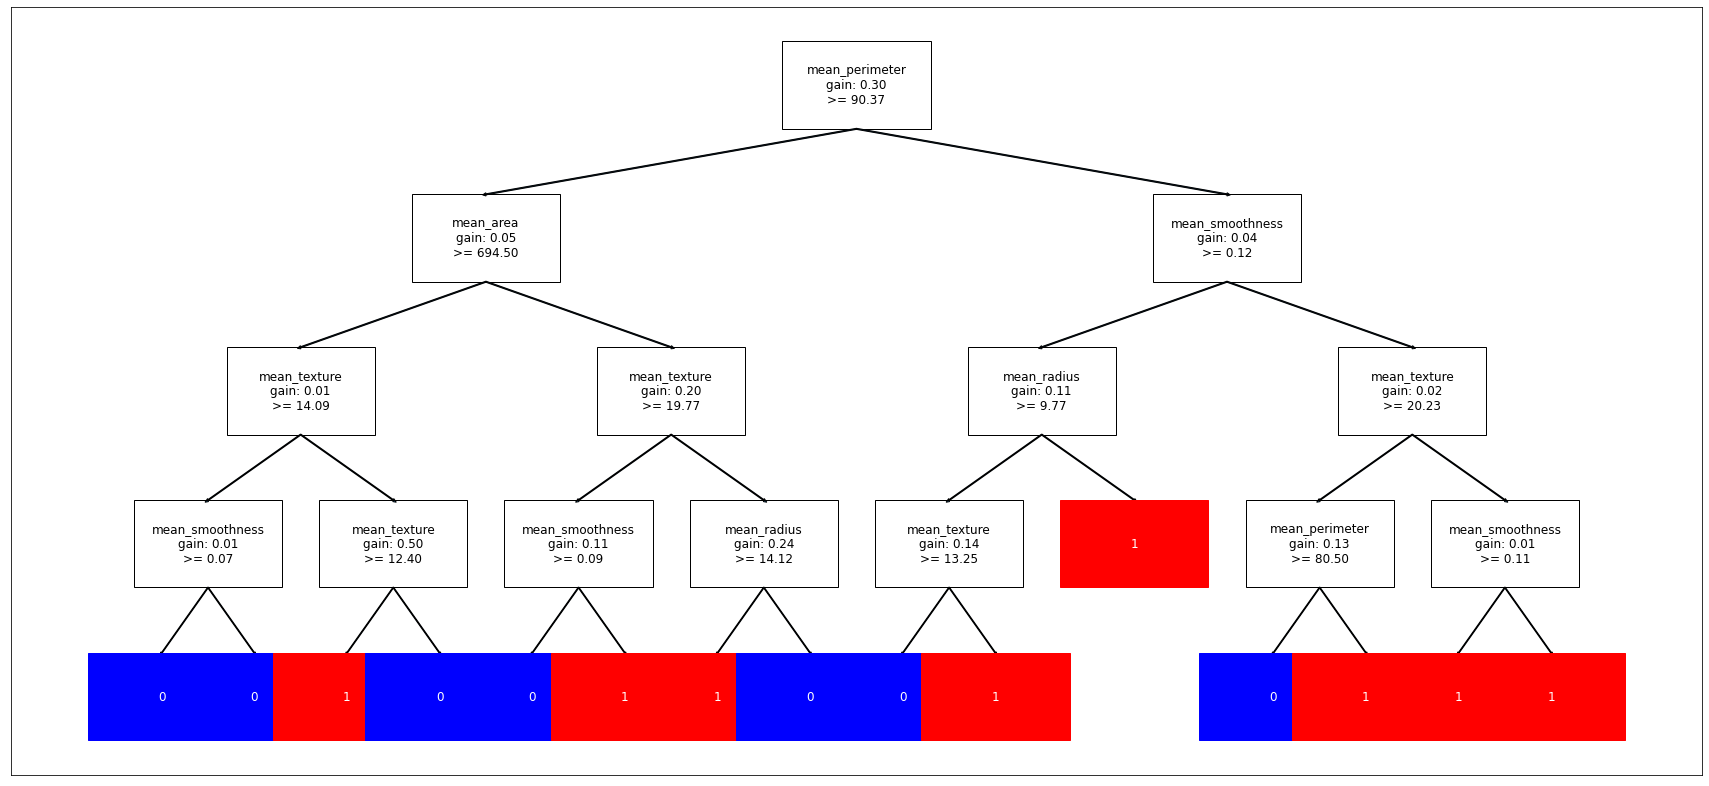

In [10]:
dt = DecisionTreeClassifier(criterion='gini_index')
dt.fit(df)
dt.draw_tree()

In [11]:
predicts, score = dt.score(test)
print(f"score: {score*100:.2f}%")

score: 95.45%


## Try with a bigger max Depth

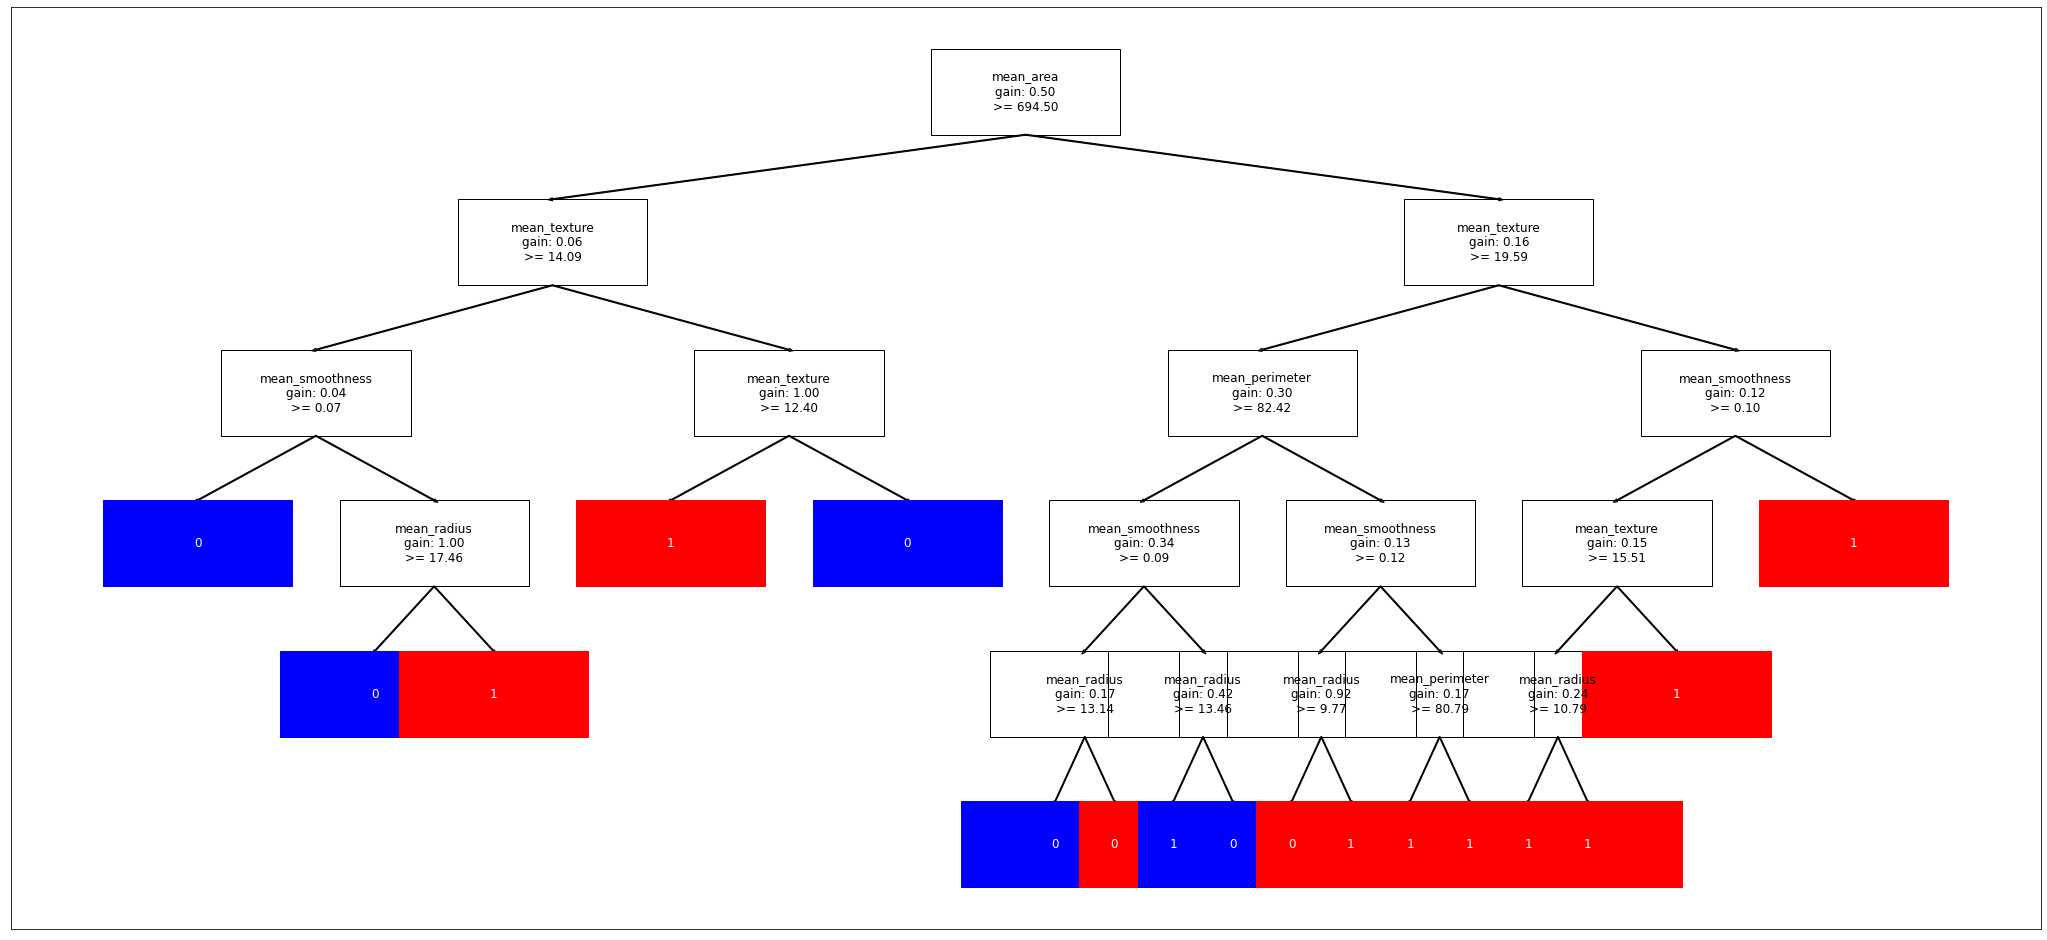

In [12]:
dt = DecisionTreeClassifier(max_depth=5, criterion='entropy')
dt.fit(df)
dt.draw_tree()

In [13]:
predicts, score = dt.score(test)
print(f"score: {score*100:.2f}%")

score: 94.44%
